In [1]:
# Load the Excel file
file_path = "All Data.xlsx"


Using XGBoost to forecast...
Forecast Results:
Forecast = 3371.28, MAE = 621.28, RMSE = 621.28
95% Confidence Interval: [1568.90, 3916.16]


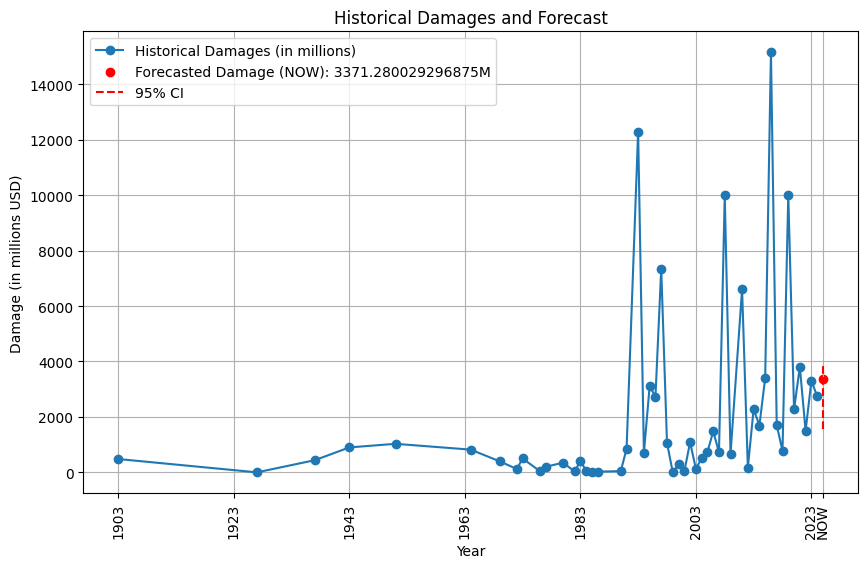

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Load the Excel file 
def load_data(file_path):
    try:
        return pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

# Preprocessing function
def preprocess_data(data, country, disaster_type):
    filtered_data = data[(data['ISO'] == country.upper()) &
                         (data['Disaster Type'] == disaster_type)].copy()
    if filtered_data.empty:
        return None

    filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
    damage_data = filtered_data[['Year', "Total Damage ('000 US$)"]].dropna()
    
    # Group by year and sum the damages
    historical_data = damage_data.groupby('Year')["Total Damage ('000 US$)"].sum().reset_index()
    if historical_data.empty:
        return None
    historical_data = historical_data.sort_values('Year')  
    
    # Convert to millions and set index
    historical_data['Total Damage (Millions)'] = historical_data["Total Damage ('000 US$)"] / 1000
    historical_data.set_index('Year', inplace=True)
    return historical_data

# XGBoost forecast function with bootstrapped confidence interval
def forecast_damage_xgboost(historical_data):
    try:
        train = historical_data[:-1]
        X_train = np.arange(len(train)).reshape(-1, 1)
        y_train = train.values.flatten()

        model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
        model.fit(X_train, y_train)

        X_test = np.array([[len(train)]])
        forecast = model.predict(X_test)[0]

        # Bootstrap confidence interval
        boot_preds = []
        for _ in range(100):
            idx = np.random.choice(len(X_train), len(X_train), replace=True)
            model.fit(X_train[idx], y_train[idx])
            boot_preds.append(model.predict(X_test)[0])
        lower = np.percentile(boot_preds, 2.5)
        upper = np.percentile(boot_preds, 97.5)

        return round(forecast, 2), round(lower, 2), round(upper, 2)
    except Exception as e:
        print(f"XGBoost model fitting failed: {e}")
        return None, None, None

# Evaluate model performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error([y_true], [y_pred])
    rmse = sqrt(mean_squared_error([y_true], [y_pred]))
    return mae, rmse

# Forecast function
def forecast_damage(data, country, disaster_type):
    historical_data = preprocess_data(data, country, disaster_type)
    if historical_data is None:
        print(f"No historical data available for {disaster_type} in {country}.")
        return

    print("\nUsing XGBoost to forecast...")

    forecast, lower, upper = forecast_damage_xgboost(historical_data['Total Damage (Millions)'])

    # Evaluate
    mae, rmse = evaluate_model(historical_data.iloc[-1]['Total Damage (Millions)'], forecast)

    print("Forecast Results:")
    print(f"95% Confidence Interval: [{lower:.2f}, {upper:.2f}]")

    plot_forecast(historical_data, forecast, lower, upper)

# Plot function with red CI line
def plot_forecast(historical_data, forecasted_value, lower, upper):
    next_year = historical_data.index[-1] + 1

    plt.figure(figsize=(10, 6))
    plt.plot(historical_data.index, historical_data['Total Damage (Millions)'], label="Historical Damages (in millions)", marker='o')
    plt.scatter(next_year, forecasted_value, color='red', label=f"Forecasted Damage (NOW): {forecasted_value}M")
    
    plt.vlines(x=next_year, ymin=lower, ymax=upper, colors='red', linestyle='--', label="95% CI")

    plt.title("Historical Damages and Forecast")
    plt.xlabel("Year")
    plt.ylabel("Damage (in millions USD)")
    plt.legend()
    plt.grid()

    year_ticks = list(range(historical_data.index.min(), historical_data.index.max() + 1, 20)) + [next_year]
    year_labels = [str(year) for year in year_ticks[:-1]] + ['NOW']

    plt.xticks(year_ticks, labels=year_labels, rotation=90)
    plt.show()

# Main program
if __name__ == "__main__":
    file_path = "All Data.xlsx"
    data = load_data(file_path)
    if data is not None:
        country = input("Enter the country (ISO code, e.g., 'USA'): ").strip().upper()
        disaster_type = input("Enter the disaster type (e.g., 'Storm'): ").strip()
        forecast_damage(data, country, disaster_type)
